## Testing out the model

#### Fetch the data

In [ ]:
!pip install kaggle ## As only needed to fetch data, not included in requirements.txt

### Go to kaggle account, and create a new token. It should download a json, upload it when running the next cell.

In [6]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"reckerdev","key":"fa5b0322fb5320c61a73e9102ad094c1"}'}

In [7]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [8]:
!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy -p /content/dataset --unzip


Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 99% 71.0M/71.5M [00:03<00:00, 24.3MB/s]
100% 71.5M/71.5M [00:03<00:00, 23.9MB/s]


#### Get the libs

In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import dataloader,DataLoader
import matplotlib.pyplot as plt

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
train_dir = "/content/dataset/Combined Dataset/train"
test_dir = "/content/dataset/Combined Dataset/test"


#### Data Loading

In [11]:
# Transform for training dataset
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),               # Resize to 128x128
    transforms.ToTensor(),                       # Convert image to PyTorch tensor
])

# Transform for test dataset
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [12]:
## Loading the dataset

train_dataset = ImageFolder(root=train_dir,transform=train_transform)
test_dataset = ImageFolder(root=test_dir,transform=test_transform)

In [14]:
train_dataset.classes

['Mild Impairment',
 'Moderate Impairment',
 'No Impairment',
 'Very Mild Impairment']

Get 10 random samples from Train-Data

Label: 2 , Class: No Impairment


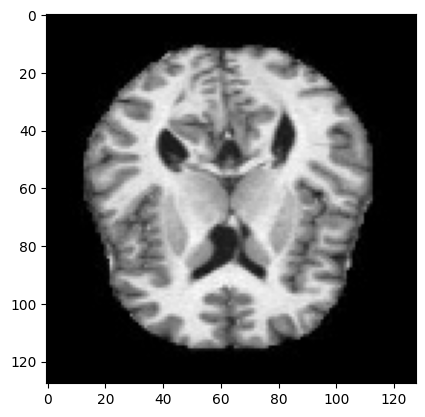

Label: 3 , Class: Very Mild Impairment


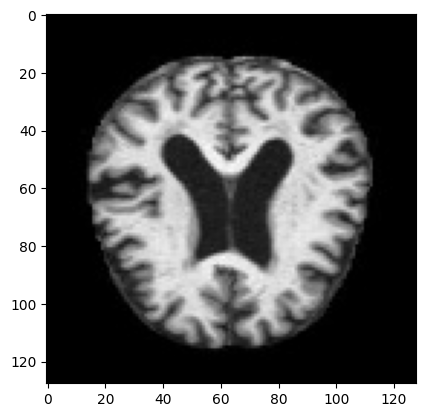

Label: 3 , Class: Very Mild Impairment


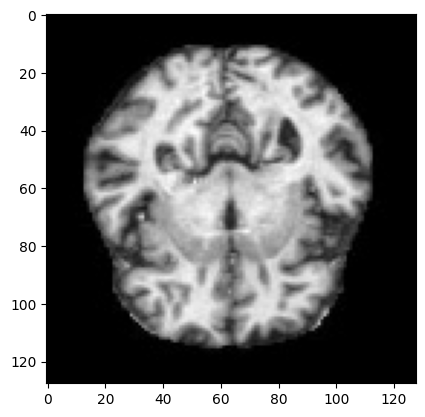

Label: 2 , Class: No Impairment


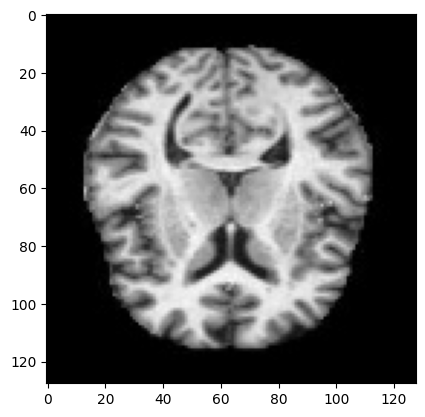

Label: 3 , Class: Very Mild Impairment


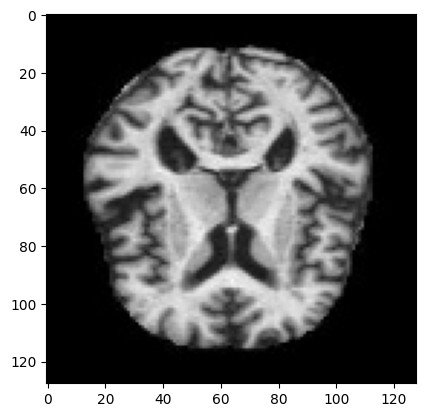

In [52]:
# prompt: Get 10 random data samples, and their label from the train_loader

import random

num_samples = 5
random_indices = random.sample(range(len(test_dataset)), num_samples)
random_eval_data = [test_dataset[i] for i in random_indices]

for data, label in random_eval_data:
    print(f"Label: {label} , Class: {test_dataset.classes[label]}")
    plt.imshow(data.permute(1, 2, 0))
    plt.show()
  # You can further process the image data here (e.g., display it)
  # plt.imshow(image.permute(1, 2, 0)) # Example: Display image if needed
  # plt.show()

In [53]:
random_eval_dataloader = DataLoader(random_eval_data, batch_size=num_samples, shuffle=True)

## Load the model

In [21]:
class AlzheimerDetector(nn.Module):
  """
  Model Arch replicates TinyVGG model
  from CNN explainer website

  """

  def __init__(self, input_shape:int, hidden_units:int, output_shape:int,image_dimension:int):
    super().__init__()
    self.conv_block_1=nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2=nn.Sequential(
    nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2)
    )

    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*image_dimension//2//2*image_dimension//2//2,
                  out_features=output_shape)
    )

  def forward(self,x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))



In [22]:
loaded_model=AlzheimerDetector(input_shape=3,hidden_units=10,output_shape=4,image_dimension=128).to(device)

In [29]:
if torch.cuda.is_available():
  loaded_model.load_state_dict(torch.load(f="/content/alz_CNN.pt", weights_only=True ))
else:
  loaded_model.load_state_dict(torch.load(f="/content/alz_CNN.pt", weights_only=True ,map_location=torch.device('cpu')))

## Evaluation of Model

In [2]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 27.8 MB/s eta 0:00:00


In [3]:
import mlxtend
import torchmetrics
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [33]:
def make_predictions(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
):
    y_preds = []
    y_true = []

    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in tqdm(dataloader, desc="Making predictions..."):
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_logit = model(X)

            # Get prediction probabilities and predicted labels
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

            # Collect predictions and true labels
            y_preds.append(y_pred.cpu())
            y_true.append(y.cpu())

    # Combine all predictions and true labels into tensors
    y_preds = torch.cat(y_preds)
    y_true = torch.cat(y_true)

    return y_preds, y_true


In [54]:
y_preds_eval,y_true_eval=make_predictions(model=loaded_model,
                 dataloader=random_eval_dataloader)

Making predictions...: 100%|██████████| 1/1 [00:00<00:00, 18.81it/s]


In [56]:
# y_preds_eval, test_dataset.classes[y_preds_eval.item()],y_true_eval,test_dataset.classes[y_true_eval.item()]

# Convert the tensors to numpy arrays for easier indexing
y_preds_eval_np = y_preds_eval.cpu().numpy()
y_true_eval_np = y_true_eval.cpu().numpy()

# Print the predictions and true labels for each item in the batch
for i in range(len(y_preds_eval_np)):
    print(f"Prediction: {test_dataset.classes[y_preds_eval_np[i]]}, True Label: {test_dataset.classes[y_true_eval_np[i]]}")

Prediction: No Impairment, True Label: No Impairment
Prediction: Very Mild Impairment, True Label: Very Mild Impairment
Prediction: No Impairment, True Label: Very Mild Impairment
Prediction: No Impairment, True Label: No Impairment
Prediction: Very Mild Impairment, True Label: Very Mild Impairment


In [4]:
## Freeze dependencies
!pip freeze > requirements.txt